In [1]:
import json
import pandas as pd
import numpy as np
import os
from glob import glob
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.ml as M
import pyspark.sql.functions as F
import pyspark.sql.types as T
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from sklearn.feature_extraction.text import CountVectorizer
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
SparkContext.setSystemProperty('spark.executor.memory', '32g')
sc = SparkContext("local", "App Name")
sc.setLogLevel("ERROR")
spark = SparkSession(sc)
spark.conf.set('spark.ui.showConsoleProgress', True)
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [2]:
posts = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/raw/posts/*.csv')
posts = pd.concat([pd.read_csv(i) for i in posts], ignore_index = True)
posts.head()

,id,author,title,selftext,num_comments,created_utc,full_link,subreddit,score
0,fsogd7,da-doggo2468,Some diamond armor perler beads I made,NaN,8,1585699169,https://www.reddit.com/r/Minecraft/comments/fs...,Minecraft,24
1,fsog50,PsaPanic,Xbox to PC cross play not working?,Me and my girlfriend are tryna play on my Xbox...,17,1585699150,https://www.reddit.com/r/Minecraft/comments/fs...,Minecraft,1
2,fsofzi,rubychoco99,Are there any shaders just for lighting?,I don’t want shaders that change what blocks l...,6,1585699135,https://www.reddit.com/r/Minecraft/comments/fs...,Minecraft,3
3,fsofsb,greengamer01,Had a dream that minecraft came out on the psp...,NaN,5,1585699116,https://www.reddit.com/r/Minecraft/comments/fs...,Minecraft,5
4,fsofom,starBURST312,My iron farm was looking pretty basic... so I ...,NaN,12,1585699106,https://www.reddit.com/r/Minecraft/comments/fs...,Minecraft,17


In [3]:
posts.id.nunique()

250000

In [4]:
comments = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/raw/comments/*')
comments = spark.read.format("csv").option("header", "true").load(comments)

In [5]:
comments.count()

2770517

In [6]:
comments.show()

+-------+-------------------+-----------+------------+-------------+---------+------------+
|     id|             author|created_utc|is_submitter|    subreddit|  link_id|send_replies|
+-------+-------------------+-----------+------------+-------------+---------+------------+
|fm2b5i7|     LesserPyrenees| 1585693985|       False|todayilearned|t3_fsmwuu|        True|
|fm2b6h8|clearliquidclearjar| 1585693999|       False|todayilearned|t3_fsmwuu|        True|
|fm2bb71|       PorkfatWilly| 1585694072|       False|todayilearned|t3_fsmwuu|        True|
|fm2bmo3|        TippsAttack| 1585694253|       False|todayilearned|t3_fsn07n|        True|
|fm2btww|          agent3dev| 1585694366|       False|todayilearned|t3_fsmwuu|        True|
|fm2c6eb|      iAmH3r3ToH3lp| 1585694560|       False|todayilearned|t3_fsmwuu|        True|
|fm2cdqh|      AutoModerator| 1585694673|       False|todayilearned|t3_fsn65j|       False|
|fm2cs79|      iAmH3r3ToH3lp| 1585694899|       False|todayilearned|t3_fsmu6g|  

In [7]:
comments.select('link_id').distinct().count()

177908

In [8]:
comments.groupBy(F.col('is_submitter')).count().show()

+------------+-------+
|is_submitter|  count|
+------------+-------+
|        True| 276309|
|       False|2494208|
+------------+-------+



In [9]:
comments.select('author').distinct().count()

695560

In [10]:
filepath = "/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/raw"

In [11]:
subreddit_info = {'subreddit':[],'num_post':[],'total_comment':[],'avg_comment':[],'top_num_comment':[]}
for filename in os.listdir(filepath + '/posts'):
    if filename.endswith(".csv"):
        subreddit = pd.read_csv(os.path.join(filepath + '/posts', filename))
        #subreddit name
        subreddit_info['subreddit'].append(filename.split('.')[0])
        subreddit_info['num_post'].append(len(subreddit))
        subreddit_info['total_comment'].append(subreddit['num_comments'].sum())
        subreddit_info['avg_comment'].append(int(subreddit['num_comments'].sum()/len(subreddit)))
        subreddit_info['top_num_comment'].append(subreddit['num_comments'].max())
    #break

In [12]:
pd.DataFrame(subreddit_info).sort_values('total_comment',ascending = False)

,subreddit,num_post,total_comment,avg_comment,top_num_comment
19,todayilearned,5000,194798,38,4142
42,amitheasshole,5000,158348,31,2561
35,classicwow,5000,148426,29,1585
45,twoxchromosomes,5000,126261,25,4609
8,dndnext,5000,126085,25,1272
21,space,5000,122510,24,5349
16,ffxiv,5000,103658,20,892
36,tifu,5000,99814,19,3649
30,unpopularopinion,5000,87949,17,6736
26,sysadmin,5000,87706,17,3532


In [3]:
label = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/label/*.csv')
path = '/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/label'
label_count = {'subreddit':[]}
s1 = []
#label = pd.concat([pd.read_csv(i) for i in label], ignore_index = True)
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        subreddit = pd.read_csv(os.path.join(path + '/', filename))
        if len(s1) == 0:
            s1 = subreddit['label'].value_counts()
        else:
            s1 = pd.concat([s1,subreddit['label'].value_counts()],axis = 1)
        label_count['subreddit'].append(filename.split('.')[0])

In [4]:
s1.columns = label_count['subreddit']
label_table = s1.T
label_table.columns = ['deleted','benign','hateful']
label_table

,deleted,benign,hateful
escapefromtarkov,368.0,2252.0,76.0
lifeprotips,2341.0,1642.0,6.0
twoxchromosomes,483.0,3310.0,44.0
leagueoflegends,1387.0,2247.0,19.0
thedivision,542.0,3194.0,32.0
tifu,1997.0,2793.0,98.0
amd,457.0,3067.0,3.0
destinythegame,546.0,4372.0,44.0
amitheasshole,2006.0,2682.0,26.0
dnd,273.0,2665.0,2.0


In [5]:
label_table.sort_values('hateful',ascending = False)

,deleted,benign,hateful
jokes,833.0,3947.0,144.0
unpopularopinion,2205.0,2435.0,118.0
teenagers,654.0,1957.0,114.0
tifu,1997.0,2793.0,98.0
escapefromtarkov,368.0,2252.0,76.0
destinythegame,546.0,4372.0,44.0
twoxchromosomes,483.0,3310.0,44.0
doom,359.0,1923.0,37.0
thedivision,542.0,3194.0,32.0
nba2k,852.0,2507.0,32.0


In [16]:
label_table.describe()

,deleted,benign,hateful
count,50.000000,48.000000,48.000000
mean,693.760000,2818.541667,24.083333
std,634.307096,986.755460,32.500627
min,101.000000,350.000000,1.000000
25%,273.750000,2250.750000,5.750000
50%,431.500000,2707.000000,11.000000
75%,810.000000,3223.000000,26.250000
max,2341.000000,4796.000000,144.000000


In [7]:
label = glob('/datasets/dsc180a-wi20-public/Malware/group_data/group_02/data/label/*')
label = pd.concat([pd.read_csv(i) for i in label], ignore_index = True)

In [8]:
post_label = label.merge(posts,on = 'id')

In [10]:
post_label_neg = post_label[post_label['label'] == 1.0]

In [9]:
post_label_pos =  post_label[post_label['label'] == 0]

In [13]:
post_label.groupby('label').agg({'num_comments' : ['min', 'max','count','mean']})

num_comments                          
               min    max   count       mean
label                                       
-1.0             0   3718   34688   2.234346
 0.0             0  15348  135290  13.501486
 1.0             0   1874    1156  19.160900

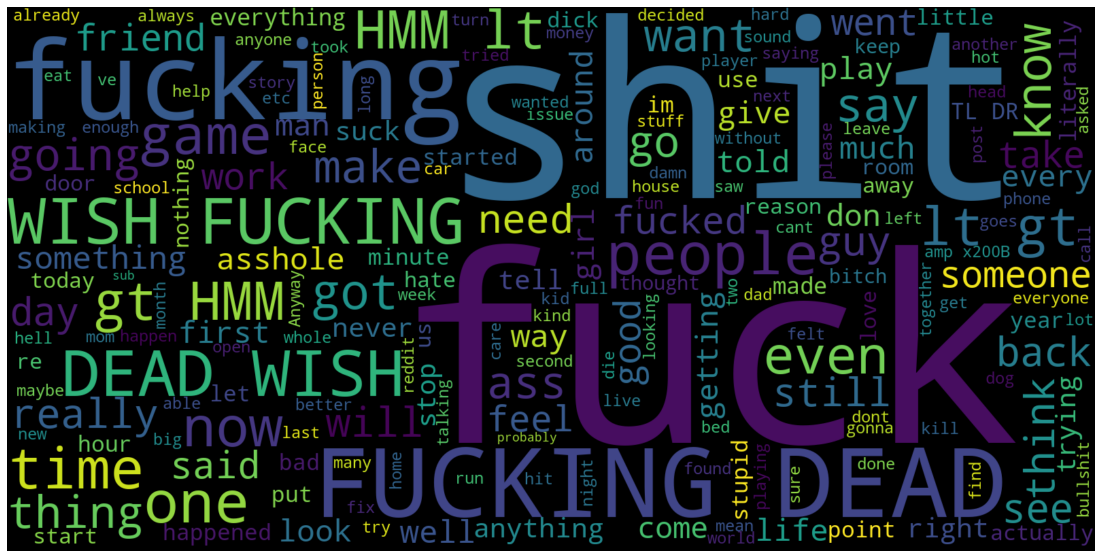

In [6]:
text = " ".join(review for review in post_label_neg.selftext)

# Create and generate a word cloud image:
wordcloud = WordCloud(width = 1600,height = 800).generate(text)

# Display the generated image:
plt.figure(figsize = (20,10))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [7]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(post_label_neg.selftext, 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
df2.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')

fucking 1366
just 688
fuck 677
like 602
shit 566
dead 418
wish 401
people 315
don 301
time 296
gt 275
lt 266
hmm 264
game 249
know 238
got 233
ass 202
ve 198
going 187
want 181


In [8]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(post_label_neg.selftext, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['title' , 'count'])
df4.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

fucking dead 389
wish fucking 388
dead wish 386
gt hmm 263
hmm lt 263
lt gt 263
tl dr 78
amp x200b 68
don know 47
sex sex 38
feel like 29
fuck fuck 28
just fucking 26
piece shit 25
don want 25
like fuck 24
holy shit 22
don care 22
like fucking 22
year old 21
